In [5]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [6]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Pharmaceutical stocks

### Vaxart, Inc. (Small Cap)

In [9]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/VXRT_data.csv")
print(df.head())

         Date  previous_1d      EMA_12   willr_14    OBV_7  labels
0  2000-01-21      437.250  350.035133  -6.976744  42909.0     0.0
1  2000-01-24      515.625  375.510497 -10.606061  67630.0     2.0
2  2000-01-25      424.875  383.105036 -43.939394  53407.0     2.0
3  2000-01-26      453.750  393.973492 -33.333333  57201.0     2.0
4  2000-01-27      420.750  398.092955 -50.000000  54669.0     2.0


In [10]:
df.set_index('Date', inplace=True)

In [11]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [12]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [13]:
v = X.reshape(X.shape[0],15, 4)
v[0]

array([[0.36666667, 0.        , 1.        , 0.        ],
       [1.        , 0.27037275, 0.93394991, 1.        ],
       [0.26666667, 0.3509744 , 0.32731512, 0.4246592 ],
       [0.5       , 0.46632248, 0.52033528, 0.57813195],
       [0.23333333, 0.51004277, 0.21701789, 0.47570891],
       [0.33333333, 0.56724259, 0.30458651, 0.54840015],
       [0.        , 0.54829003, 0.        , 0.46466567],
       [0.06666667, 0.54572373, 0.0609173 , 0.54900692],
       [0.43333333, 0.61763989, 0.39596246, 0.74208163],
       [0.6       , 0.71216823, 0.54825571, 0.87140488],
       [0.56666667, 0.78541851, 0.47700422, 0.62072732],
       [0.6       , 0.85413476, 0.50950252, 0.75292262],
       [0.6       , 0.91227927, 0.43540641, 0.75292262],
       [0.7       , 0.9816842 , 0.41676349, 0.95598884],
       [0.5       , 1.        , 0.07334122, 0.81465151]])

In [14]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [17]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2936 - accuracy: 0.5192 - mse: 0.4518 - weighted_accuracy: 0.3142 - weighted_mse: 0.5380 - val_loss: 0.2993 - val_accuracy: 0.0464 - val_mse: 0.3546 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3546
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2119 - accuracy: 0.3596 - mse: 0.7794 - weighted_accuracy: 0.4162 - weighted_mse: 0.7783 - val_loss: 0.2902 - val_accuracy: 0.0464 - val_mse: 0.3837 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3837
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1923 - accuracy: 0.3317 - mse: 1.0204 - weighted_accuracy: 0.4477 - weighted_mse: 1.0131 - val_loss: 0.2792 - val_accuracy: 0.0464 - val_mse: 0.4188 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4188
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1853 - accuracy: 0.3274 - mse: 1.1493 - weighted_accuracy: 0.4973 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1399 - accuracy: 0.4315 - mse: 1.5218 - weighted_accuracy: 0.7239 - weighted_mse: 1.4445 - val_loss: 0.1842 - val_accuracy: 0.3962 - val_mse: 1.5042 - val_weighted_accuracy: 0.3962 - val_weighted_mse: 1.5042
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.4681 - mse: 1.5056 - weighted_accuracy: 0.7251 - weighted_mse: 1.4387 - val_loss: 0.1888 - val_accuracy: 0.3730 - val_mse: 1.5182 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 1.5182
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1372 - accuracy: 0.4586 - mse: 1.5388 - weighted_accuracy: 0.7342 - weighted_mse: 1.4608 - val_loss: 0.1742 - val_accuracy: 0.4816 - val_mse: 1.5039 - val_weighted_accuracy: 0.4816 - val_weighted_mse: 1.5039
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.4597 - mse: 1.5616 - weighted_accuracy: 0.7448 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1101 - accuracy: 0.6212 - mse: 1.9483 - weighted_accuracy: 0.8253 - weighted_mse: 1.9412 - val_loss: 0.1732 - val_accuracy: 0.5416 - val_mse: 2.0963 - val_weighted_accuracy: 0.5416 - val_weighted_mse: 2.0963
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1083 - accuracy: 0.6088 - mse: 1.9851 - weighted_accuracy: 0.8246 - weighted_mse: 1.9548 - val_loss: 0.1549 - val_accuracy: 0.6280 - val_mse: 2.0063 - val_weighted_accuracy: 0.6280 - val_weighted_mse: 2.0063
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1080 - accuracy: 0.6125 - mse: 1.9851 - weighted_accuracy: 0.8223 - weighted_mse: 1.9630 - val_loss: 0.1632 - val_accuracy: 0.5774 - val_mse: 2.0304 - val_weighted_accuracy: 0.5774 - val_weighted_mse: 2.0304
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1057 - accuracy: 0.6214 - mse: 2.0183 - weighted_accuracy: 0.8187 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0836 - accuracy: 0.7129 - mse: 2.6996 - weighted_accuracy: 0.8786 - weighted_mse: 2.7493 - val_loss: 0.1571 - val_accuracy: 0.6481 - val_mse: 2.7390 - val_weighted_accuracy: 0.6481 - val_weighted_mse: 2.7390
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0832 - accuracy: 0.7347 - mse: 2.6827 - weighted_accuracy: 0.8813 - weighted_mse: 2.6950 - val_loss: 0.1684 - val_accuracy: 0.6038 - val_mse: 2.7831 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 2.7831
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0814 - accuracy: 0.7379 - mse: 2.7443 - weighted_accuracy: 0.8894 - weighted_mse: 2.7753 - val_loss: 0.1785 - val_accuracy: 0.5848 - val_mse: 2.9729 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 2.9729
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0819 - accuracy: 0.7389 - mse: 2.8325 - weighted_accuracy: 0.8879 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.8224 - mse: 3.9333 - weighted_accuracy: 0.9243 - weighted_mse: 3.9352 - val_loss: 0.1752 - val_accuracy: 0.6533 - val_mse: 4.1055 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 4.1055
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.8217 - mse: 3.9700 - weighted_accuracy: 0.9272 - weighted_mse: 3.9705 - val_loss: 0.1550 - val_accuracy: 0.7418 - val_mse: 4.3714 - val_weighted_accuracy: 0.7418 - val_weighted_mse: 4.3714
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.8193 - mse: 4.0439 - weighted_accuracy: 0.9211 - weighted_mse: 4.0387 - val_loss: 0.1753 - val_accuracy: 0.6860 - val_mse: 4.5858 - val_weighted_accuracy: 0.6860 - val_weighted_mse: 4.5858
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0623 - accuracy: 0.8277 - mse: 4.0846 - weighted_accuracy: 0.9331 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0444 - accuracy: 0.8786 - mse: 5.5962 - weighted_accuracy: 0.9553 - weighted_mse: 5.3894 - val_loss: 0.1754 - val_accuracy: 0.7460 - val_mse: 5.8707 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 5.8707
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.8746 - mse: 5.7243 - weighted_accuracy: 0.9487 - weighted_mse: 5.5245 - val_loss: 0.1730 - val_accuracy: 0.7534 - val_mse: 6.2007 - val_weighted_accuracy: 0.7534 - val_weighted_mse: 6.2007
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0444 - accuracy: 0.8825 - mse: 5.8189 - weighted_accuracy: 0.9498 - weighted_mse: 5.5528 - val_loss: 0.1781 - val_accuracy: 0.7513 - val_mse: 6.1270 - val_weighted_accuracy: 0.7513 - val_weighted_mse: 6.1270
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.8854 - mse: 5.8679 - weighted_accuracy: 0.9561 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9181 - mse: 7.6644 - weighted_accuracy: 0.9664 - weighted_mse: 7.0819 - val_loss: 0.1989 - val_accuracy: 0.7555 - val_mse: 7.5420 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 7.5420
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0333 - accuracy: 0.9146 - mse: 7.7367 - weighted_accuracy: 0.9651 - weighted_mse: 7.1712 - val_loss: 0.1991 - val_accuracy: 0.7935 - val_mse: 8.4258 - val_weighted_accuracy: 0.7935 - val_weighted_mse: 8.4258
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9096 - mse: 7.8335 - weighted_accuracy: 0.9632 - weighted_mse: 7.3115 - val_loss: 0.2266 - val_accuracy: 0.7050 - val_mse: 8.2681 - val_weighted_accuracy: 0.7050 - val_weighted_mse: 8.2681
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.9204 - mse: 7.8370 - weighted_accuracy: 0.9707 - 

In [21]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23786026239395142
Test accuracy: 0.7260273694992065


In [22]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.4819856  -3.0869856   1.4733844 ]
 [-0.14152712 -2.366791   -0.7798032 ]
 [-3.849906   -1.069698    0.10475988]
 ...
 [ 0.30626333 -3.392776   -1.0585811 ]
 [ 0.74033964 -4.6121693  -1.7178255 ]
 [ 0.3376006  -1.7437309  -1.5561123 ]]


Counter({2: 739, 0: 106, 1: 104})

In [23]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 46, 1: 44})

In [24]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 12
actual buys but predicted sell: 3
actual buys but predicted hold: 29
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 39
actual holds but predicted buy: 91
actual holds but predicted sell: 97
actual predicted holds: 671
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 13.043478260869565%
Percentage holds correct: 78.11408614668218%
actual buys: 44
actual sells: 46
actual holds: 859


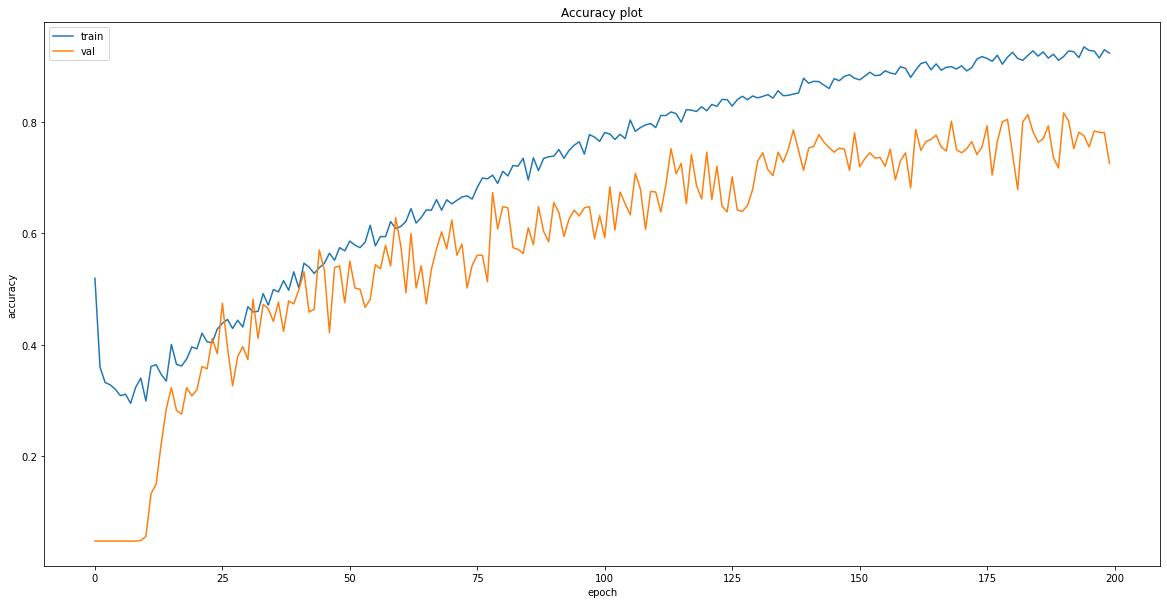

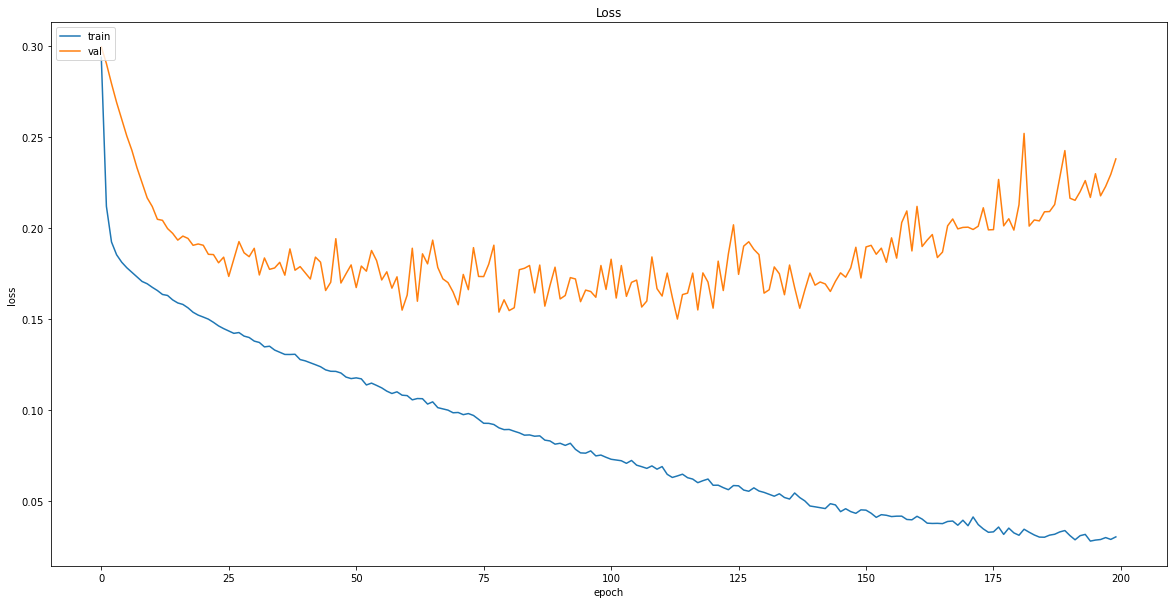

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
# Save model
model.save("models/{}".format('VXRT_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/VXRT_time_series_lstm_buy_hold_sell.model\assets


## Inovio Pharmaceuticals, Inc. (Mid Cap)

In [27]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/INO_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14    OBV_7  labels
0  2000-01-21         51.0  54.535133 -80.952381 -17732.0     2.0
1  2000-01-24         56.0  54.760497 -57.142857 -10257.0     2.0
2  2000-01-25         58.0  55.258882 -47.619048  -8463.0     2.0
3  2000-01-26         59.0  55.834439 -42.857143  -4944.0     2.0
4  2000-01-27         57.0  56.013756 -52.380952  -5313.0     2.0


In [28]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,51.0,54.535133,-80.952381,-17732.0,2.0
2000-01-24,56.0,54.760497,-57.142857,-10257.0,2.0
2000-01-25,58.0,55.258882,-47.619048,-8463.0,2.0
2000-01-26,59.0,55.834439,-42.857143,-4944.0,2.0
2000-01-27,57.0,56.013756,-52.380952,-5313.0,2.0


In [29]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [30]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [31]:
y = labels
y = np.array(y)

In [32]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [33]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [34]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [36]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2951 - accuracy: 0.5237 - mse: 0.4354 - weighted_accuracy: 0.3151 - weighted_mse: 0.5222 - val_loss: 0.2994 - val_accuracy: 0.0453 - val_mse: 0.3540 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3540
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.3570 - mse: 0.7499 - weighted_accuracy: 0.4501 - weighted_mse: 0.7368 - val_loss: 0.2906 - val_accuracy: 0.0453 - val_mse: 0.3842 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3842
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.2871 - mse: 1.0175 - weighted_accuracy: 0.4915 - weighted_mse: 0.9804 - val_loss: 0.2791 - val_accuracy: 0.0453 - val_mse: 0.4225 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4225
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1803 - accuracy: 0.2903 - mse: 1.1754 - weighted_accuracy: 0.5146 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1332 - accuracy: 0.4434 - mse: 1.6310 - weighted_accuracy: 0.7368 - weighted_mse: 1.5932 - val_loss: 0.1816 - val_accuracy: 0.4373 - val_mse: 1.6147 - val_weighted_accuracy: 0.4373 - val_weighted_mse: 1.6147
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1325 - accuracy: 0.4579 - mse: 1.6522 - weighted_accuracy: 0.7383 - weighted_mse: 1.6172 - val_loss: 0.1850 - val_accuracy: 0.4236 - val_mse: 1.6971 - val_weighted_accuracy: 0.4236 - val_weighted_mse: 1.6971
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1303 - accuracy: 0.4715 - mse: 1.6765 - weighted_accuracy: 0.7361 - weighted_mse: 1.6412 - val_loss: 0.1906 - val_accuracy: 0.4004 - val_mse: 1.7149 - val_weighted_accuracy: 0.4004 - val_weighted_mse: 1.7149
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.4652 - mse: 1.7006 - weighted_accuracy: 0.7393 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1032 - accuracy: 0.6207 - mse: 2.2681 - weighted_accuracy: 0.8351 - weighted_mse: 2.3442 - val_loss: 0.1559 - val_accuracy: 0.6112 - val_mse: 2.3566 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 2.3566
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1029 - accuracy: 0.6122 - mse: 2.2578 - weighted_accuracy: 0.8412 - weighted_mse: 2.3220 - val_loss: 0.1626 - val_accuracy: 0.6048 - val_mse: 2.4421 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 2.4421
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1018 - accuracy: 0.6491 - mse: 2.2729 - weighted_accuracy: 0.8381 - weighted_mse: 2.3704 - val_loss: 0.1808 - val_accuracy: 0.5469 - val_mse: 2.5600 - val_weighted_accuracy: 0.5469 - val_weighted_mse: 2.5600
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1012 - accuracy: 0.6141 - mse: 2.3633 - weighted_accuracy: 0.8401 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0812 - accuracy: 0.7276 - mse: 3.1069 - weighted_accuracy: 0.8816 - weighted_mse: 3.2911 - val_loss: 0.1752 - val_accuracy: 0.6059 - val_mse: 3.4668 - val_weighted_accuracy: 0.6059 - val_weighted_mse: 3.4668
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0809 - accuracy: 0.7363 - mse: 3.1547 - weighted_accuracy: 0.8941 - weighted_mse: 3.3403 - val_loss: 0.1828 - val_accuracy: 0.5869 - val_mse: 3.4458 - val_weighted_accuracy: 0.5869 - val_weighted_mse: 3.4458
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0779 - accuracy: 0.7355 - mse: 3.1452 - weighted_accuracy: 0.8957 - weighted_mse: 3.3474 - val_loss: 0.1748 - val_accuracy: 0.6249 - val_mse: 3.4278 - val_weighted_accuracy: 0.6249 - val_weighted_mse: 3.4278
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0785 - accuracy: 0.7363 - mse: 3.2125 - weighted_accuracy: 0.8886 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0609 - accuracy: 0.8248 - mse: 4.3130 - weighted_accuracy: 0.9247 - weighted_mse: 4.5306 - val_loss: 0.1855 - val_accuracy: 0.6628 - val_mse: 4.7032 - val_weighted_accuracy: 0.6628 - val_weighted_mse: 4.7032
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.8230 - mse: 4.4238 - weighted_accuracy: 0.9277 - weighted_mse: 4.6227 - val_loss: 0.1687 - val_accuracy: 0.6849 - val_mse: 4.5146 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 4.5146
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0591 - accuracy: 0.8261 - mse: 4.4669 - weighted_accuracy: 0.9308 - weighted_mse: 4.6348 - val_loss: 0.1748 - val_accuracy: 0.6870 - val_mse: 4.7281 - val_weighted_accuracy: 0.6870 - val_weighted_mse: 4.7281
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0609 - accuracy: 0.8143 - mse: 4.5196 - weighted_accuracy: 0.9227 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.8730 - mse: 6.0588 - weighted_accuracy: 0.9480 - weighted_mse: 6.1270 - val_loss: 0.1879 - val_accuracy: 0.7071 - val_mse: 6.1339 - val_weighted_accuracy: 0.7071 - val_weighted_mse: 6.1339
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.8730 - mse: 6.0721 - weighted_accuracy: 0.9535 - weighted_mse: 6.1435 - val_loss: 0.1699 - val_accuracy: 0.7650 - val_mse: 6.5487 - val_weighted_accuracy: 0.7650 - val_weighted_mse: 6.5487
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.8783 - mse: 6.1776 - weighted_accuracy: 0.9480 - weighted_mse: 6.2024 - val_loss: 0.1842 - val_accuracy: 0.7323 - val_mse: 7.1537 - val_weighted_accuracy: 0.7323 - val_weighted_mse: 7.1537
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.8812 - mse: 6.3175 - weighted_accuracy: 0.9546 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9102 - mse: 8.0702 - weighted_accuracy: 0.9634 - weighted_mse: 7.9031 - val_loss: 0.1984 - val_accuracy: 0.7787 - val_mse: 8.8480 - val_weighted_accuracy: 0.7787 - val_weighted_mse: 8.8480
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.9191 - mse: 8.2065 - weighted_accuracy: 0.9685 - weighted_mse: 8.0306 - val_loss: 0.2176 - val_accuracy: 0.7208 - val_mse: 8.6107 - val_weighted_accuracy: 0.7208 - val_weighted_mse: 8.6107
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9086 - mse: 8.3519 - weighted_accuracy: 0.9647 - weighted_mse: 8.1547 - val_loss: 0.1983 - val_accuracy: 0.8082 - val_mse: 9.2181 - val_weighted_accuracy: 0.8082 - val_weighted_mse: 9.2181
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9146 - mse: 8.2559 - weighted_accuracy: 0.9650 - 

In [37]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22382815182209015
Test accuracy: 0.767123281955719


In [38]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.9772068  -5.4682617   2.1956296 ]
 [-1.6716775  -5.889905    0.57284707]
 [-4.565231   -0.45934606  0.35515335]
 ...
 [-3.8830743  -5.4510565   3.9684439 ]
 [-7.303396   -1.1256268   0.78393126]
 [-4.3983703  -2.4765797   1.6381438 ]]


Counter({2: 803, 1: 66, 0: 80})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [40]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 43
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 37
actual holds but predicted buy: 65
actual holds but predicted sell: 75
actual predicted holds: 723
Percentage buys correct: 0.0%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 83.77752027809966%
actual buys: 43
actual sells: 43
actual holds: 863


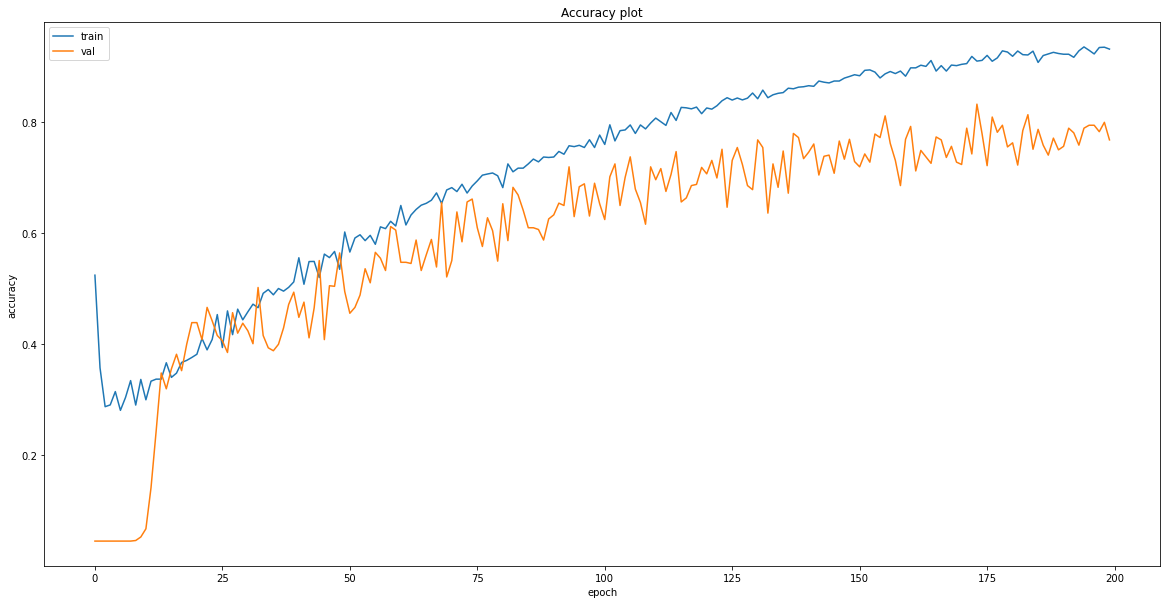

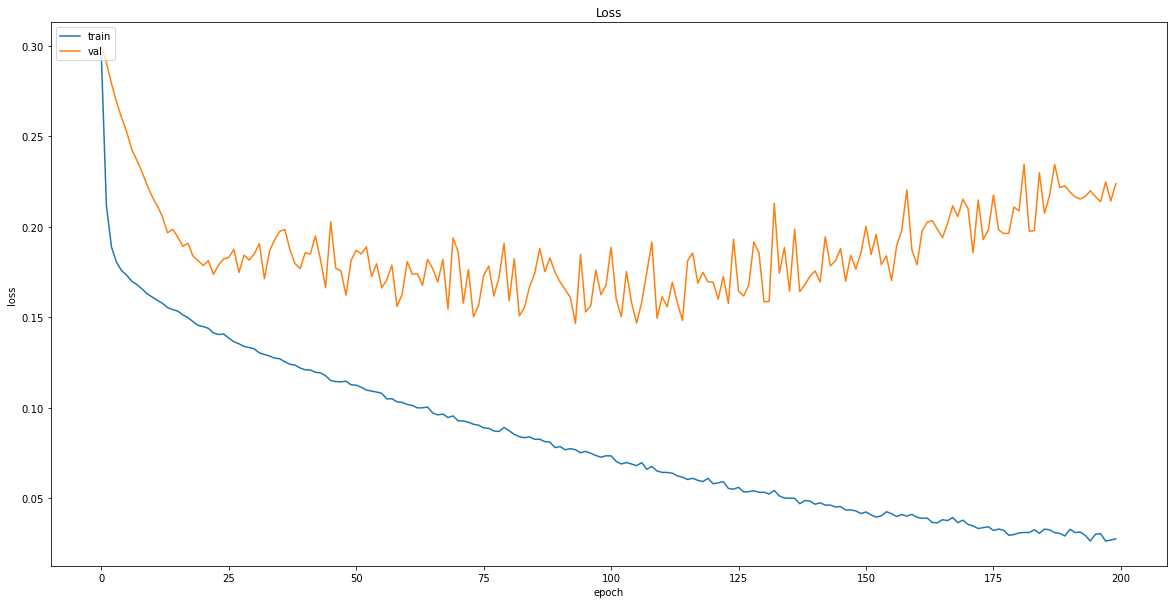

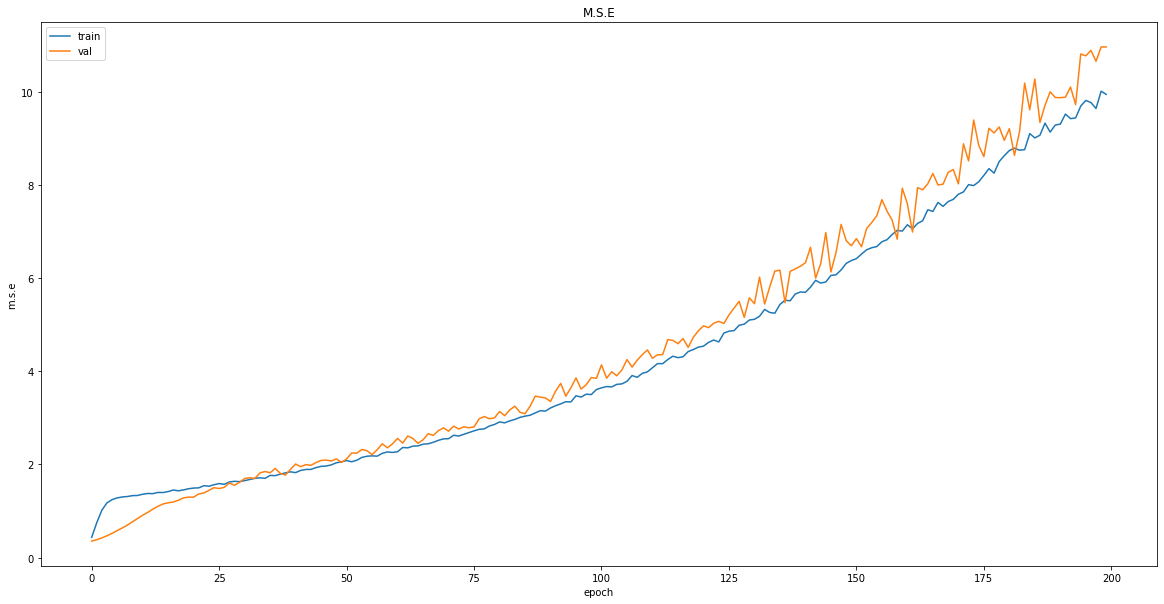

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
# Save model
model.save("models/{}".format('INO_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/INO_time_series_lstm_buy_hold_sell.model\assets


## Novavax, Inc. (Large Cap)

In [43]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/NVAX_data.csv")
print(df.head())

         Date  previous_1d      EMA_12   willr_14    OBV_7  labels
0  2000-01-21       123.75  111.044132  -0.000000    330.0     0.0
1  2000-01-24       145.00  116.268112  -9.090909  10530.0     2.0
2  2000-01-25       130.00  118.380710 -36.363636   6930.0     2.0
3  2000-01-26       132.50  120.552908 -31.818182   9665.0     2.0
4  2000-01-27       140.00  123.544769 -18.181818  11870.0     2.0


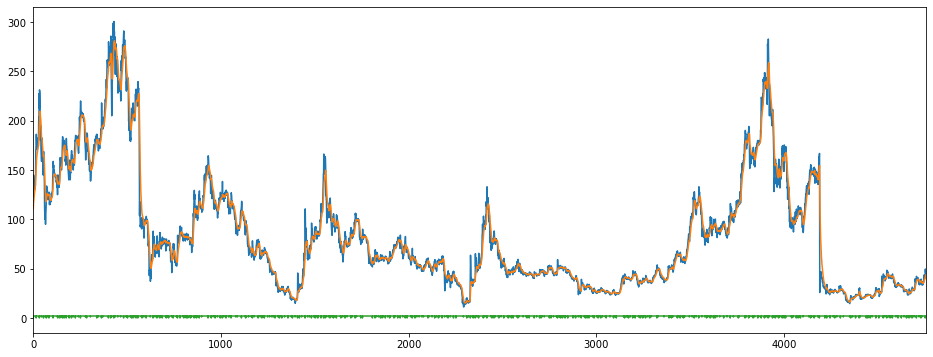

In [44]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [45]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,123.75,111.044132,-0.000000,330.0,0.0
2000-01-24,145.00,116.268112,-9.090909,10530.0,2.0
2000-01-25,130.00,118.380710,-36.363636,6930.0,2.0
2000-01-26,132.50,120.552908,-31.818182,9665.0,2.0
2000-01-27,140.00,123.544769,-18.181818,11870.0,2.0


In [46]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [47]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [48]:
y = labels
y = np.array(y)

In [49]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [50]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [51]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2929 - accuracy: 0.5092 - mse: 0.4430 - weighted_accuracy: 0.3260 - weighted_mse: 0.5285 - val_loss: 0.2997 - val_accuracy: 0.0464 - val_mse: 0.3542 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3542
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2075 - accuracy: 0.3272 - mse: 0.7843 - weighted_accuracy: 0.4777 - weighted_mse: 0.7607 - val_loss: 0.2906 - val_accuracy: 0.0464 - val_mse: 0.3862 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3862
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1870 - accuracy: 0.2998 - mse: 1.0287 - weighted_accuracy: 0.4941 - weighted_mse: 1.0023 - val_loss: 0.2795 - val_accuracy: 0.0464 - val_mse: 0.4266 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4266
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1792 - accuracy: 0.2921 - mse: 1.1666 - weighted_accuracy: 0.5319 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1367 - accuracy: 0.4141 - mse: 1.6018 - weighted_accuracy: 0.7069 - weighted_mse: 1.5059 - val_loss: 0.1815 - val_accuracy: 0.4215 - val_mse: 1.5121 - val_weighted_accuracy: 0.4215 - val_weighted_mse: 1.5121
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1347 - accuracy: 0.4310 - mse: 1.6125 - weighted_accuracy: 0.7226 - weighted_mse: 1.5308 - val_loss: 0.1864 - val_accuracy: 0.4015 - val_mse: 1.6246 - val_weighted_accuracy: 0.4015 - val_weighted_mse: 1.6246
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.4486 - mse: 1.6056 - weighted_accuracy: 0.7253 - weighted_mse: 1.5271 - val_loss: 0.1781 - val_accuracy: 0.4394 - val_mse: 1.5696 - val_weighted_accuracy: 0.4394 - val_weighted_mse: 1.5696
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1336 - accuracy: 0.4283 - mse: 1.6479 - weighted_accuracy: 0.7158 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1093 - accuracy: 0.5988 - mse: 2.0340 - weighted_accuracy: 0.8160 - weighted_mse: 1.9797 - val_loss: 0.1857 - val_accuracy: 0.4784 - val_mse: 2.0803 - val_weighted_accuracy: 0.4784 - val_weighted_mse: 2.0803
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1075 - accuracy: 0.6030 - mse: 2.0514 - weighted_accuracy: 0.8174 - weighted_mse: 2.0029 - val_loss: 0.1651 - val_accuracy: 0.5722 - val_mse: 2.1864 - val_weighted_accuracy: 0.5722 - val_weighted_mse: 2.1864
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1051 - accuracy: 0.6164 - mse: 2.0586 - weighted_accuracy: 0.8317 - weighted_mse: 2.0265 - val_loss: 0.1736 - val_accuracy: 0.5448 - val_mse: 2.0954 - val_weighted_accuracy: 0.5448 - val_weighted_mse: 2.0954
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1051 - accuracy: 0.6154 - mse: 2.0743 - weighted_accuracy: 0.8274 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0828 - accuracy: 0.7258 - mse: 2.7469 - weighted_accuracy: 0.8845 - weighted_mse: 2.7082 - val_loss: 0.1847 - val_accuracy: 0.5616 - val_mse: 3.0931 - val_weighted_accuracy: 0.5616 - val_weighted_mse: 3.0931
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 0.7334 - mse: 2.7881 - weighted_accuracy: 0.8819 - weighted_mse: 2.7661 - val_loss: 0.2005 - val_accuracy: 0.5342 - val_mse: 2.9377 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 2.9377
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0817 - accuracy: 0.7342 - mse: 2.8038 - weighted_accuracy: 0.8894 - weighted_mse: 2.8086 - val_loss: 0.1730 - val_accuracy: 0.6112 - val_mse: 2.9386 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 2.9386
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0820 - accuracy: 0.7487 - mse: 2.8556 - weighted_accuracy: 0.8820 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.8166 - mse: 3.8161 - weighted_accuracy: 0.9216 - weighted_mse: 3.7123 - val_loss: 0.2032 - val_accuracy: 0.6112 - val_mse: 3.7816 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 3.7816
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0608 - accuracy: 0.8145 - mse: 3.8555 - weighted_accuracy: 0.9265 - weighted_mse: 3.7451 - val_loss: 0.1677 - val_accuracy: 0.6986 - val_mse: 4.2571 - val_weighted_accuracy: 0.6986 - val_weighted_mse: 4.2571
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0642 - accuracy: 0.8122 - mse: 3.9725 - weighted_accuracy: 0.9068 - weighted_mse: 3.8907 - val_loss: 0.1609 - val_accuracy: 0.7197 - val_mse: 4.1471 - val_weighted_accuracy: 0.7197 - val_weighted_mse: 4.1471
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0609 - accuracy: 0.8298 - mse: 3.9895 - weighted_accuracy: 0.9321 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.8736 - mse: 5.3312 - weighted_accuracy: 0.9482 - weighted_mse: 5.0429 - val_loss: 0.1947 - val_accuracy: 0.6934 - val_mse: 5.3023 - val_weighted_accuracy: 0.6934 - val_weighted_mse: 5.3023
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 0.8707 - mse: 5.3150 - weighted_accuracy: 0.9490 - weighted_mse: 5.0112 - val_loss: 0.1833 - val_accuracy: 0.7345 - val_mse: 5.7023 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 5.7023
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0458 - accuracy: 0.8783 - mse: 5.4161 - weighted_accuracy: 0.9517 - weighted_mse: 5.1403 - val_loss: 0.1790 - val_accuracy: 0.7376 - val_mse: 5.7420 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 5.7420
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0487 - accuracy: 0.8704 - mse: 5.4908 - weighted_accuracy: 0.9415 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9065 - mse: 7.0463 - weighted_accuracy: 0.9601 - weighted_mse: 6.4456 - val_loss: 0.1957 - val_accuracy: 0.7871 - val_mse: 7.9438 - val_weighted_accuracy: 0.7871 - val_weighted_mse: 7.9438
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9052 - mse: 7.1722 - weighted_accuracy: 0.9634 - weighted_mse: 6.5684 - val_loss: 0.2040 - val_accuracy: 0.7777 - val_mse: 7.7024 - val_weighted_accuracy: 0.7777 - val_weighted_mse: 7.7024
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0363 - accuracy: 0.9125 - mse: 7.2716 - weighted_accuracy: 0.9642 - weighted_mse: 6.6002 - val_loss: 0.2115 - val_accuracy: 0.7260 - val_mse: 6.8211 - val_weighted_accuracy: 0.7260 - val_weighted_mse: 6.8211
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.9117 - mse: 7.2440 - weighted_accuracy: 0.9639 - 

In [54]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2347515970468521
Test accuracy: 0.7439410090446472


In [55]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-6.0115848   1.4005978  -0.9805994 ]
 [-0.936159   -4.7453823   0.7239724 ]
 [-1.5632511  -3.9255538   1.2067589 ]
 ...
 [-3.3998377  -2.95572     1.4695978 ]
 [-2.5221987  -3.6709006   2.2368395 ]
 [-0.40728062 -3.0494983  -0.02669887]]


Counter({1: 96, 2: 767, 0: 86})

In [56]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 41, 1: 44})

In [57]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 34
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 37
actual holds but predicted buy: 86
actual holds but predicted sell: 82
actual predicted holds: 696
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 80.55555555555556%
actual buys: 44
actual sells: 41
actual holds: 864


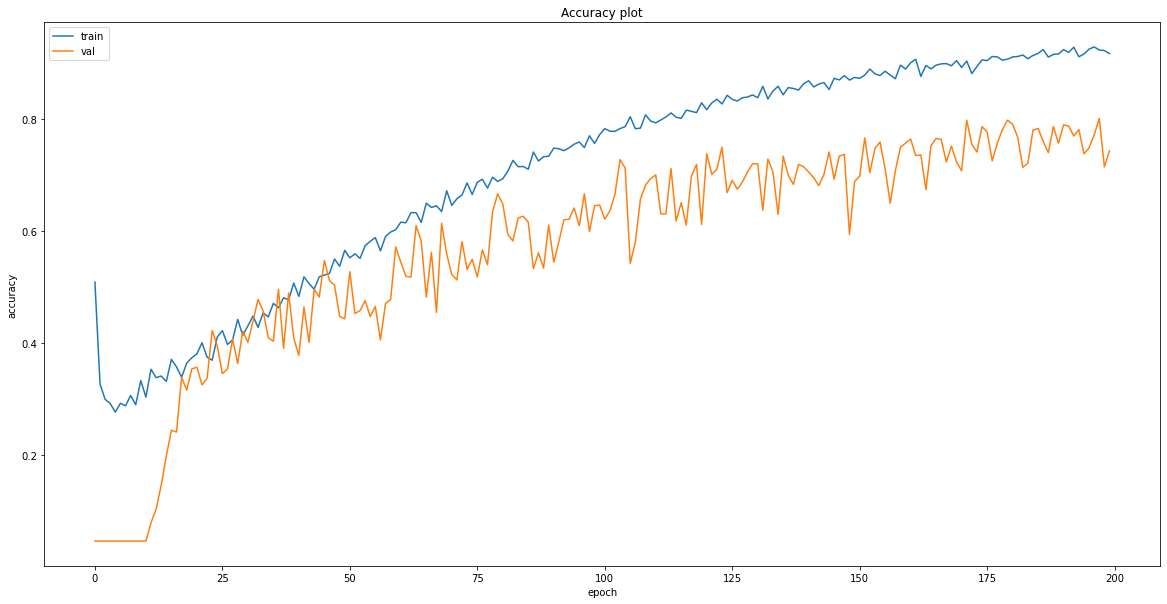

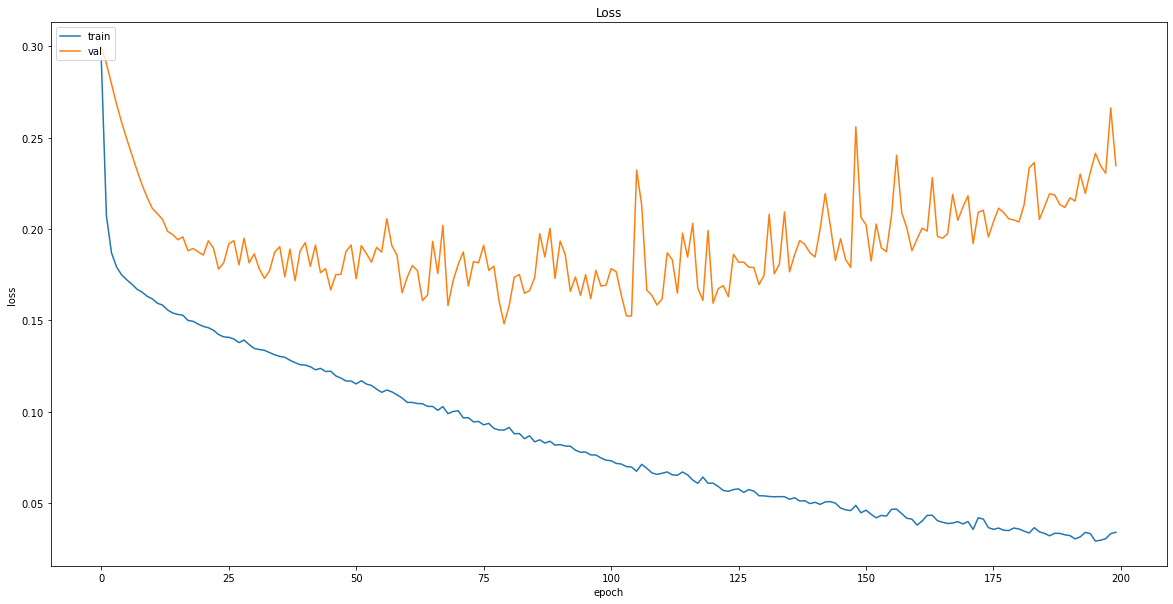

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
# Save model
model.save("models/{}".format('NVAX_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/NVAX_time_series_lstm_buy_hold_sell.model\assets
